# Yutube Datset Preprocessing with CER filtering


Hallucination 확인 작업을 위해 Whisper STT 모델을 통과한 text output을 데이터프레임 형태로 저장한다.  
텍스트 변환 저장 코드 -> 560분 기준 텍스트 읽는 코드 2시간에서 2분으로 단축

위스퍼 전사 작동 시간이 너무 길어 최적화 작업 진행

### Prepare Environment

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install datasets>=2.6.1
!pip install git+https://github.com/huggingface/transformers
!pip install evaluate>=0.30
!pip install jiwer
!pip install accelerate -U
!pip install transformers[torch]
!pip install wandb
!pip install ffmpeg
!pip install -U openai-whisper

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.31.0, but you have requests 2.32.3 which is incompatible.
  Cloning https://github.com/huggingface/transformers to /tmp/pip-req-build-cbdcv6an
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers /tmp/pip-req-build-cbdcv6an
  Resolved https://github.com/huggingface/transformers to commit 14ff5dd962c1bd0a4e3adaac347ba396d8df5add
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for transformers: filename=transformers-4.42.0.dev0-py3-none-any.whl size=9140611 sha256=6b56a2d26b4b2e2c049f005cd70b1ccbdfb39a8b64f7142036e851ef866c89c8
  Stored in directory: /tmp/pip-ephem-wheel-cache-pamapfrx/wheels/c0/14/d6/6c9a5582d2ac191ec0a483be151a4

In [ ]:
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

import os
import glob
from concurrent.futures import ThreadPoolExecutor, as_completed

import wave
import contextlib
import soundfile as sf
from IPython.display import Audio, display

from transformers import WhisperFeatureExtractor, WhisperTokenizer, WhisperForConditionalGeneration
import torch
import whisper
from datasets import load_metric

### 1. 자막 & 오디오 데이터 경로  

In [ ]:
# csv 파일 경로 지정
df = pd.read_csv("/content/drive/MyDrive/NexoChat_share_data/youtube_dataset_30sec/csv_file/working_transcript.csv", index_col=0)
df.head()

### 2. 오디오 데이터 길이 확인

In [ ]:
def get_audio_length(audio_file):
    try:
        if audio_file.endswith('.wav'):
            with contextlib.closing(wave.open(audio_file, 'r')) as f:
                frames = f.getnframes()
                rate = f.getframerate()
                duration = frames / float(rate)
                return duration
        else:
            f = sf.SoundFile(audio_file)
            return len(f) / f.samplerate
    except Exception as e:
        print(f"Error processing file {audio_file}: {e}")
        return 0.0

total_length = 0.0

# 병렬 처리를 사용하여 각 오디오 파일의 길이를 합산
with ThreadPoolExecutor(max_workers=16) as executor:
    future_to_file = {executor.submit(get_audio_length, file): file for file in raw_data_list}
    for future in tqdm(as_completed(future_to_file), total=len(future_to_file), desc="Calculating audio lengths"):
        total_length += future.result()

total_length_minutes = total_length / 60
total_length_hours = total_length_minutes / 60

print()
print(f"Total length of all audio files: {total_length:.2f} seconds")
print(f"Total length of all audio files: {total_length_minutes:.2f} minutes")
print(f"Total length of all audio files: {total_length_hours:.2f} hours")


Calculating audio lengths: 100%|██████████| 977/977 [00:03<00:00, 304.54it/s]

Total length of all audio files: 27294.43 seconds
Total length of all audio files: 454.91 minutes
Total length of all audio files: 7.58 hours


### 3. 텍스트 전처리 & 오디오 확인



In [ ]:
# 전처리 함수 정의


,transcript,STT_transcript,raw_data,CER
137,몰랐으면 놓쳤을 금전적인 혜택을 늘려준다 우리가 막 미래를 만들자라기 보다는 아니 ...,몰랐으면 놓쳤을 어떤 금전적인 혜택을 늘려준다. 우리가 막 미래를 만들자라기보다는...,/content/drive/MyDrive/NexoChat_share_data/you...,12.121212
138,다음 소식은 동네 전체가 대기줄이라니 여기 어딘가요 크리스마스 연휴를 맞아서 대전 ...,다음 소식은 동네 전체가 대기줄이라�니 여기 오세요. 크리스마스 연휴를 받아서 대...,/content/drive/MyDrive/NexoChat_share_data/you...,26.068376


In [ ]:
# 전처리 완료된 csv 파일 저장
df.to_csv("/content/drive/MyDrive/NexoChat_share_data/youtube_dataset_30sec/csv_file/working/working_transcript.csv")

### 4. Whisper 전사 CER 필터링
여기서부터는 GPU 사용

오디오 데이터를 whisper에 통과시켜서 나온 텍스트 정보와 유튜브 자막 데이터를 비교하여 CER이 일정 기준 이상인 데이터만 학습용으로 사용

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

import os
import glob
from concurrent.futures import ThreadPoolExecutor, as_completed

import wave
import contextlib
import soundfile as sf
from IPython.display import Audio, display

from transformers import WhisperFeatureExtractor, WhisperTokenizer, WhisperForConditionalGeneration
import torch
import whisper
from datasets import load_metric

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/NexoChat_share_data/youtube_dataset_30sec/csv_file/working/working_transcript.csv", index_col=0)
df.tail()

,transcript,raw_data,text_data
972,태생이 뷰티 유튜버 인가 봐 이제 크림으로 마무리를 해줄 건데 제가 사실 막 여러 ...,/content/drive/MyDrive/NexoChat_share_data/you...,/content/drive/MyDrive/NexoChat_share_data/you...
973,이렇게 정말 입에 담기도 좀 불편한 시술 부작용 브이로그와 제가 진짜 진정 시킬 때...,/content/drive/MyDrive/NexoChat_share_data/you...,/content/drive/MyDrive/NexoChat_share_data/you...
974,머랭이들 항상 조심하시고요 괜한 시술은 부작용을 불러올 수도 있다 라는 거 진짜 이...,/content/drive/MyDrive/NexoChat_share_data/you...,/content/drive/MyDrive/NexoChat_share_data/you...
975,이런 마음으로 봐주시면 감사하겠습니다 앞으로 또 위기를 기회로 더 좋은 진정 스킨 ...,/content/drive/MyDrive/NexoChat_share_data/you...,/content/drive/MyDrive/NexoChat_share_data/you...
976,머랭이들 이번 영상도 봐주셔서 감사하고요 이 피부 상태는 앞으로 쭉 영상에서 어떻게...,/content/drive/MyDrive/NexoChat_share_data/you...,/content/drive/MyDrive/NexoChat_share_data/you...


#### Whisper 전사

In [ ]:
# Whisper 전사 CER 기록
# 디바이스 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
# 모델 불러오기
model = whisper.load_model("base")

# 오디오 로드 함수
def transcribe_audio(audio_input, sr=16000):
    audio = whisper.load_audio(audio_input, sr=sr)
    result = model.transcribe(audio, fp16=False, language='ko')
    return result

# 전체 데이터 whisper 전사
transcriptions = []

for audio_file_path in tqdm(df['raw_data']):
    transcription = transcribe_audio(audio_file_path)
    transcriptions.append(transcription['text'])

_# 리스트를 새로운 열로 추가
df['STT_transcript'] = transcriptions
# 컬럼 순서 변경
df = df[['transcript', 'STT_transcript', 'raw_data']]

df.head()

cuda


100%|███████████████████████████████████████| 139M/139M [00:01<00:00, 94.7MiB/s]
100%|██████████| 977/977 [41:20<00:00,  2.54s/it]


,transcript,STT_transcript,raw_data
0,레모나들 안녕하세요 최모나입니다 제가 다이어트를 한창 할 때 의심도 많고 궁금증도...,"네모나 대란 안녕하세요, 채원아입니다. 제가 다이어트를 한창할 때 의심도 많고 궁...",/content/drive/MyDrive/NexoChat_share_data/you...
1,제가 이제 제약 회사 지인의 도움을 빌려가지고 레모나들한테 오늘 최대한 정보를 전...,제가 이제 제약해서 지인의 도움을 빌려가지고 레몬하들한테 오늘 최대한 정보를 좀 ...,/content/drive/MyDrive/NexoChat_share_data/you...
2,요런 거는 이제 기본 상식으로 알고 계시고 본격적으로 이야기를 해볼게요! 다이어...,이런 거는 이제 진짜 기본 상식으로 알고 계시고 본격적으로 이야기를 해 볼게요. ...,/content/drive/MyDrive/NexoChat_share_data/you...
3,잔티움 나이트버닝이랑 그리고 메타그린슬림이잖아요 제가 좋아하는 제품들이거든요 효과도...,그 잔티움 나이트 버닝이랑 그리고 메타그인 슬림이잖아요. 제가 좋아하는 제품들이거...,/content/drive/MyDrive/NexoChat_share_data/you...
4,그다음은 광고 문구 같은 보조제는 절대로 없다! 진짜 이거 보시는 업체 관계자분들...,그 다음은 광고 문구 같은 보조제는 절대로 없다. 진짜 이거 보지는 없애 관계자분...,/content/drive/MyDrive/NexoChat_share_data/you...


In [ ]:
df.isnull().sum()

transcript        4
STT_transcript    0
raw_data          0
dtype: int64

In [ ]:
# null 값 제거
df = df.dropna().reset_index(drop=True)
df.isnull().sum()

transcript        0
STT_transcript    0
raw_data          0
dtype: int64

In [ ]:
df.tail()

,transcript,STT_transcript,raw_data
972,태생이 뷰티 유튜버 인가 봐 이제 크림으로 마무리를 해줄 건데 제가 사실 막 여러 ...,크림이 뷰티 유튜버인가 봐. 크림을 마무리를 해줄 건데 제가 사실 막 여러 개에서...,/content/drive/MyDrive/NexoChat_share_data/you...
973,이렇게 정말 입에 담기도 좀 불편한 시술 부작용 브이로그와 제가 진짜 진정 시킬 때...,이렇게 입에 담기도 불편한 시술 부작용 로그와 진짜 진정시킬 때 추천드리고 싶은 ...,/content/drive/MyDrive/NexoChat_share_data/you...
974,머랭이들 항상 조심하시고요 괜한 시술은 부작용을 불러올 수도 있다 라는 거 진짜 이...,나이들 항상 조심하시고요. 개난 시술은 부작용을 불러올 수도 있다 라는 거 진짜 ...,/content/drive/MyDrive/NexoChat_share_data/you...
975,이런 마음으로 봐주시면 감사하겠습니다 앞으로 또 위기를 기회로 더 좋은 진정 스킨 ...,마음으로 봐주시면 감사하겠습니다. 앞으로 또 이길의 기회를 또 저 좋은 진정 스킨...,/content/drive/MyDrive/NexoChat_share_data/you...
976,머랭이들 이번 영상도 봐주셔서 감사하고요 이 피부 상태는 앞으로 쭉 영상에서 어떻게...,여러분들 이번 영상도 봐주셔서 감사하세요 높이부 상태는 앞으로 쭉 영상에서 어떻게...,/content/drive/MyDrive/NexoChat_share_data/you...


In [ ]:
# 전사 완료된 데이터 저장
df.to_csv("/content/drive/MyDrive/NexoChat_share_data/youtube_dataset_30sec/csv_file/working/working_STT_transcript.csv")

#### CER 비교

In [ ]:
# CER metric 로드
cer_metric = load_metric("cer")

# CER 저장
cer_diff = []
for i in tqdm(range(len(df))):
    try:
      prediction = [df['transcript'][i]]
      reference = [df['STT_transcript'][i]]
      cer = cer_metric.compute(predictions=prediction, references=reference)
      cer_diff.append(cer * 100)
    except:
      print(i)
      cer_diff.append(0.00)

# 데이터프레임에 cer_diff 열 추가
df['CER'] = cer_diff

/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for cer contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.2/metrics/cer/cer.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
100%|██████████| 973/973 [16:24<00:00,  1.01s/it]


In [ ]:
# CER 의 평균
df['CER'].mean()

49.78327368878918

In [ ]:
print(min(df['CER']))
print(max(df['CER']))

2.5773195876288657
17000.0


In [ ]:
df.head()

,transcript,STT_transcript,raw_data,CER
0,레모나들 안녕하세요 최모나입니다 제가 다이어트를 한창 할 때 의심도 많고 궁금증도 ...,"네모나 대란 안녕하세요, 채원아입니다. 제가 다이어트를 한창할 때 의심도 많고 궁...",/content/drive/MyDrive/NexoChat_share_data/you...,53.428571
1,제가 이제 제약 회사 지인의 도움을 빌려가지고 레모나들한테 오늘 최대한 정보를 전달...,제가 이제 제약해서 지인의 도움을 빌려가지고 레몬하들한테 오늘 최대한 정보를 좀 ...,/content/drive/MyDrive/NexoChat_share_data/you...,14.718615
2,요런 거는 이제 기본 상식으로 알고 계시고 본격적으로 이야기를 해볼게요 다이어트 보...,이런 거는 이제 진짜 기본 상식으로 알고 계시고 본격적으로 이야기를 해 볼게요. ...,/content/drive/MyDrive/NexoChat_share_data/you...,13.059701
3,잔티움 나이트버닝이랑 그리고 메타그린슬림이잖아요 제가 좋아하는 제품들이거든요 효과도...,그 잔티움 나이트 버닝이랑 그리고 메타그인 슬림이잖아요. 제가 좋아하는 제품들이거...,/content/drive/MyDrive/NexoChat_share_data/you...,16.956522
4,그다음은 광고 문구 같은 보조제는 절대로 없다 진짜 이거 보시는 업체 관계자분들이 ...,그 다음은 광고 문구 같은 보조제는 절대로 없다. 진짜 이거 보지는 없애 관계자분...,/content/drive/MyDrive/NexoChat_share_data/you...,7.594937


In [ ]:
# cer 저장된 데이터 저장
df.to_csv("/content/drive/MyDrive/NexoChat_share_data/youtube_dataset_30sec/csv_file/working/working_STT_transcript.csv")

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/NexoChat_share_data/youtube_dataset_30sec/csv_file/working/working_STT_transcript.csv", index_col=0)
df.head()

,transcript,STT_transcript,raw_data,CER
0,레모나들 안녕하세요 최모나입니다 제가 다이어트를 한창 할 때 의심도 많고 궁금증도 ...,"네모나 대란 안녕하세요, 채원아입니다. 제가 다이어트를 한창할 때 의심도 많고 궁...",/content/drive/MyDrive/NexoChat_share_data/you...,53.428571
1,제가 이제 제약 회사 지인의 도움을 빌려가지고 레모나들한테 오늘 최대한 정보를 전달...,제가 이제 제약해서 지인의 도움을 빌려가지고 레몬하들한테 오늘 최대한 정보를 좀 ...,/content/drive/MyDrive/NexoChat_share_data/you...,14.718615
2,요런 거는 이제 기본 상식으로 알고 계시고 본격적으로 이야기를 해볼게요 다이어트 보...,이런 거는 이제 진짜 기본 상식으로 알고 계시고 본격적으로 이야기를 해 볼게요. ...,/content/drive/MyDrive/NexoChat_share_data/you...,13.059701
3,잔티움 나이트버닝이랑 그리고 메타그린슬림이잖아요 제가 좋아하는 제품들이거든요 효과도...,그 잔티움 나이트 버닝이랑 그리고 메타그인 슬림이잖아요. 제가 좋아하는 제품들이거...,/content/drive/MyDrive/NexoChat_share_data/you...,16.956522
4,그다음은 광고 문구 같은 보조제는 절대로 없다 진짜 이거 보시는 업체 관계자분들이 ...,그 다음은 광고 문구 같은 보조제는 절대로 없다. 진짜 이거 보지는 없애 관계자분...,/content/drive/MyDrive/NexoChat_share_data/you...,7.594937


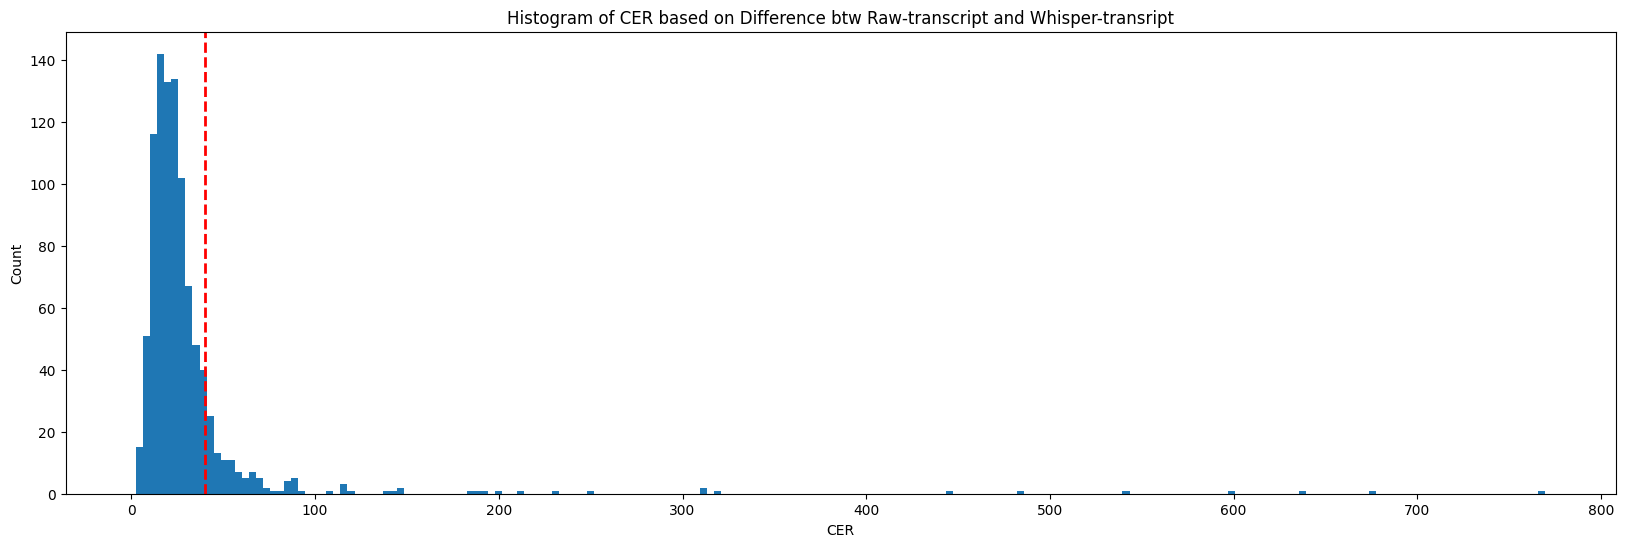

In [ ]:
# Plotting the histogram for cer_diff

# 임계값 설정
threshold = 40

plt.figure(figsize=(20, 6))
plt.hist(df[df['CER']<=2000]['CER'], bins=200)
plt.axvline(threshold, color='red', linestyle='dashed', linewidth=2)

plt.xlabel('CER')
plt.ylabel('Count')
plt.title('Histogram of CER based on Difference btw Raw-transcript and Whisper-transript')
plt.show()

In [ ]:
# CER이 threshold 이상인 데이터 개수 확인
print(len(df[df['CER'] <= threshold]))

835


In [ ]:
df[df['CER'] >= threshold]

,transcript,STT_transcript,raw_data,CER
0,레모나들 안녕하세요 최모나입니다 제가 다이어트를 한창 할 때 의심도 많고 궁금증도 ...,"네모나 대란 안녕하세요, 채원아입니다. 제가 다이어트를 한창할 때 의심도 많고 궁...",/content/drive/MyDrive/NexoChat_share_data/you...,53.428571
18,가끔씩 응급실 당직 서고 이 정도로 하게 되는데 저는 어떻게 하다보니까 보직을 그때...,"그 가끔 시장 글쎄 당직, 그 정도로 하게 되는데 저는 어떻게 하다보니까 보직을 ...",/content/drive/MyDrive/NexoChat_share_data/you...,61.556064
55,그런 것 같습니다 그래서 이게 이렇게 해서 좀 더 사회가 혹시라도 발전을 하게 되면...,그래서 이게 이렇게 해서 좀 더 사회가 혹시라도 발전하하게 되면 좀 더 안전한 사...,/content/drive/MyDrive/NexoChat_share_data/you...,40.425532
56,본 영상은 사회적 거리두기 단계에 촬영되었습니다 거의 년 동안 그 구조가 바뀌지 않...,거의 100년 동안 그 구조가 바뀌지 않고 있어요. 사실은 바꾸지 않고 있는 거죠...,/content/drive/MyDrive/NexoChat_share_data/you...,46.808511
139,불구하고 새벽부터 성심당 인근에는 가량의 케이크 구매 대기줄이 늘어섰습니다 인기 케...,새벽부터 성심당 인근에는 500m가량의 케이크 구매 대기줄이 늘입니다. 인기 케이...,/content/drive/MyDrive/NexoChat_share_data/you...,73.880597
...,...,...,...,...
927,오늘 저는 드라마 후시녹음을 하러 간다고 네 오 진짜 어후 그럼 나도 가겠네 조만간...,오늘 드라마 스시리요. 아이디어라라고 한다고? 네. 진짜? 나도 가겠네. 나도 가...,/content/drive/MyDrive/NexoChat_share_data/you...,45.291480
929,되게 잘 맞으신다 진짜 잘 맞으세요 이게 뭐가 맞아요 하나도 안 맞는 거지 아니 아...,되게 잘 맞으시니까. 진짜 잘 맞으세요? 이게 뭐가 맞아? 하나도 안 맞는 거 같...,/content/drive/MyDrive/NexoChat_share_data/you...,41.522491
933,내가 이놈의 회사 잘되나 보자 눈물의 여왕 파이팅 네 파이팅 애정해주시고 시청해주시...,내 힘에서 잘 되나 보자! 눈물에 와! 화이팅! 화이팅! 애정도 쉬고 시청해주시고...,/content/drive/MyDrive/NexoChat_share_data/you...,40.400000
937,보이세요 아우 징그러워 진짜 저 진짜 지금 일상생활 너무 힘들어서 대인기피증도 오고...,"아, 지금 진짜 저 진짜 지금 일상생활 너무 힘들어가지고 개인기 빛짐도 너무 힘들...",/content/drive/MyDrive/NexoChat_share_data/you...,85.730858


In [ ]:
# CER 기준 오름차순 조회
df[(df['CER'] >= 60)&(df['CER'] < 70)][:10]

,transcript,STT_transcript,raw_data,CER
18,가끔씩 응급실 당직 서고 이 정도로 하게 되는데 저는 어떻게 하다보니까 보직을 그때...,"그 가끔 시장 글쎄 당직, 그 정도로 하게 되는데 저는 어떻게 하다보니까 보직을 ...",/content/drive/MyDrive/NexoChat_share_data/you...,61.556064
366,마우스로 클릭해서 드래그해서 여기 떨어뜨려 주시면 됩니다 그러면 이렇게 배경 이미지...,마우스로 클릭해서 드래그에서 여기 떨어우려 주시면 됩니다. 그러면 이렇게 배경 이...,/content/drive/MyDrive/NexoChat_share_data/you...,66.450216
531,잘 되는지 한번 테스트를 해보겠습니다 저장을 해주시고 에서 재생 버튼을 눌러서 테스...,"되는지 한번 테스트를 해 보겠습니다. 해 주시고, Unity에서 재생 버튼을 눌러...",/content/drive/MyDrive/NexoChat_share_data/you...,66.356877
565,지금까지 우리가 편리한 전기를 마음껏 사용할 수 있었던 건 이들의 노력 덕분이었습니...,지금까지 우리가 편리한 전기를 마음껏 사용할 수 있었던 건 이들의 노력 떡군이었습...,/content/drive/MyDrive/NexoChat_share_data/you...,65.600000
583,지상 지원 장비가 없다면 작업하는 저 선이 활선이다라고 여겨야 한다는 뜻입니다 누군...,마트니 겪은 사고가 반복되지 않도록 미국의 전력 회사들은 협력하고 있는데요 그 중...,/content/drive/MyDrive/NexoChat_share_data/you...,68.292683
587,현장에 불안한 부분은 없는지 적정한 배치로 되어있는지를 확인하고 있습니다 작업 코치...,자극 콧취 역할을 하는 이부는 20년간 배전공사 실물을 담당해 온 현장 전문가. ...,/content/drive/MyDrive/NexoChat_share_data/you...,67.073171
591,공사 현장에서 가장 많이 발생하는 재해 중 하나가 추락 사고죠 그 순간의 공포를 느...,공사 현장에서 가장 많이 발생하는 제외 중 하나가 추락사거죠. 그 순간의 공포를 ...,/content/drive/MyDrive/NexoChat_share_data/you...,68.224299
615,부산의 한 마을 요즘 이곳 분위기가 왠지 뒤숭숭하다고 하는데요 그 이유는 정전을 시...,부산의 한 방을 요즘 이곳 분위기가 왠지 뒤숭숭하다고 하는데요. 그 이유는 정전을...,/content/drive/MyDrive/NexoChat_share_data/you...,68.181818
628,독일 시민들은 휴전 작업을 어떻게 받아들이고 있을까요 도시에서는 보통 휴전이 있다고...,독일 시민들은 휴전 작업을 어떻게 받아들이고 있을까요. 마이<|ko|> 주전공지를...,/content/drive/MyDrive/NexoChat_share_data/you...,61.290323
638,무슨 결제 몬해요 손님이 결제를 지금 저 사람들 몇 시에 지금 갑니까 전기는 몇 시...,손님이 결계를 지금 저 사람을 밀세 지금 가합니까? 정규현 미식이 뭐냐고. 하쇼에...,/content/drive/MyDrive/NexoChat_share_data/you...,60.122699


In [ ]:
from IPython.display import Audio, display

test = df[(df['CER'] >= 60)&(df['CER'] < 70)][:10]

for idx, row in test.iterrows():
    audio_file_path = row['raw_data']
    audio = whisper.load_audio(audio_file_path, sr=16000)
    print(f"Transcription {idx + 1}: {test['transcript'][idx]}")
    print(f"Whisper Transcription {idx + 1}: {test['STT_transcript'][idx]}")
    display(Audio(audio, rate=16000))

Output hidden; open in https://colab.research.google.com to view.

#### CER이 threshold 이상인 데이터 제거

In [ ]:
# 임계값 설정
threshold = 40

# cer_diff가 임계값 이하인 데이터만 필터링
filtered_df = df[df['CER'] <= threshold]
filtered_df.head()

# 결과 확인
print(f'기존 데이터 길이 : {len(df)}')
print(f'필터링된 데이터 길이 : {len(filtered_df)}')

# 필터링된 데이터프레임을 파일로 저장
filtered_df.to_csv("/content/drive/MyDrive/NexoChat_share_data/youtube_dataset_30sec/csv_file/working/working_cer_filtered.csv")

기존 데이터 길이 : 973
필터링된 데이터 길이 : 835
